<a href="https://colab.research.google.com/github/amantayal44/seq2seq-chatbot/blob/master/tpu_transformer_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Transformer using TPUs

In this notebook we train simple transformer model on cornell movie dialogue corpus using TPUs and use it for chatbot task

**Note**: Change Runtime type to TPU

## loading files from git repo

In [1]:
!git clone https://github.com/amantayal44/seq2seq-chatbot.git

Cloning into 'seq2seq-chatbot'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 1), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [4]:
!cp seq2seq-chatbot/* .

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from main import *
from model import *

## TPU/GPU initialization

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU ['10.88.55.42:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.88.55.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.88.55.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


## Loading Dataset

We use max samples 70,000 so after filtering and spliting in test,train dataset, train dataset has about 50,000 examples

In [ ]:
max_samples = 70000
max_length = 40
batch_size = 64* strategy.num_replicas_in_sync

dataset,test_dataset,tokenizer,meta = get_dataset(max_samples,max_length,batch_size,validation_split = 0.2)

9920512/9916637 [==============================] - 1s 0us/step


In [ ]:
#train_dataset size
len(list(dataset.as_numpy_iterator())) * batch_size

49152

 ## Hyperparameters 

In [ ]:
d_model = 256
dff = 1024
num_layers = 4
num_heads = 8
vocab_size = meta['vocab_size']

## Loss and Accuracy function

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_length - 1))
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_length - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


## Optimizer for transformer
transformer has optimizer with custom learning rate

In [ ]:
optimizer = tf.keras.optimizers.Adam(
        CustomSchedule(d_model),beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Initializing and compiling transformer model

In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = transformer(d_model,vocab_size,num_layers,num_heads,dff)
  model.compile(optimizer=optimizer,loss=loss_function,metrics=[accuracy])

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (PaddingMask)  (None, 1, 1, None)   0           encoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    5235456     encoder_inputs[0][0]             
                                                                 enc_padding_mask[0][0] 

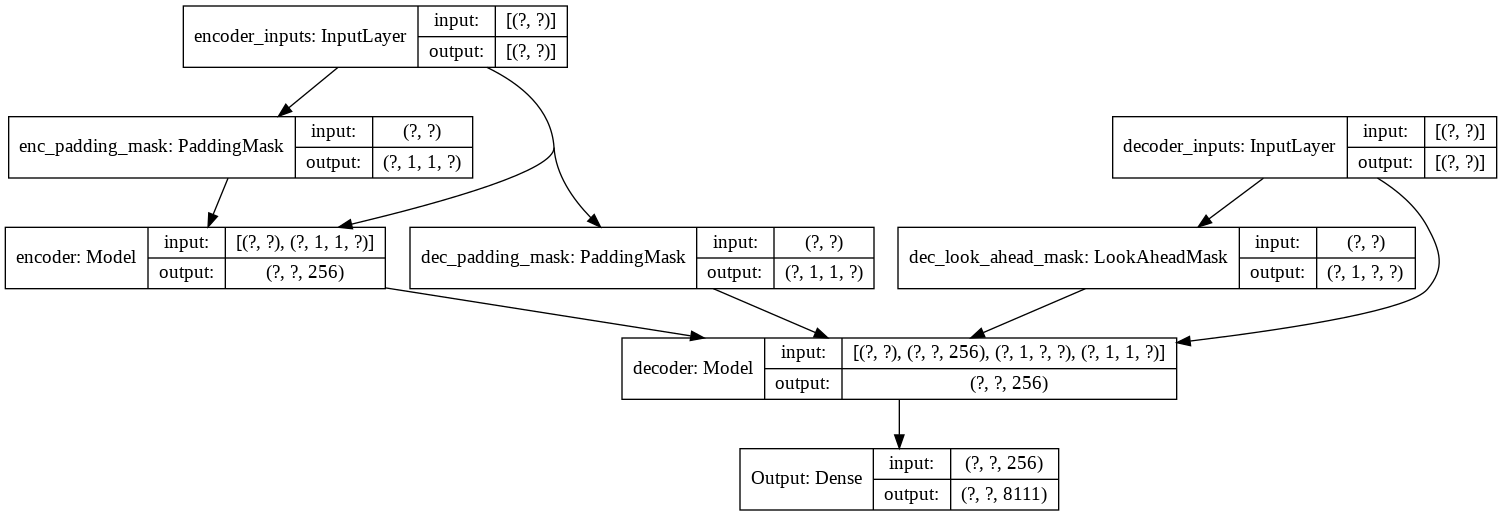

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

## Training

In [ ]:
Epochs = 40
history = model.fit(dataset,epochs=Epochs,validation_data=test_dataset)

Epoch 1/40
96/96 [==============================] - 41s 431ms/step - accuracy: 0.0175 - loss: 2.8046 - val_accuracy: 0.0256 - val_loss: 2.6651
Epoch 2/40
96/96 [==============================] - 9s 89ms/step - accuracy: 0.0256 - loss: 2.5372 - val_accuracy: 0.0256 - val_loss: 2.3282
Epoch 3/40
96/96 [==============================] - 8s 88ms/step - accuracy: 0.0353 - loss: 2.1614 - val_accuracy: 0.0447 - val_loss: 1.9828
Epoch 4/40
96/96 [==============================] - 9s 89ms/step - accuracy: 0.0530 - loss: 1.8956 - val_accuracy: 0.0650 - val_loss: 1.7776
Epoch 5/40
96/96 [==============================] - 9s 89ms/step - accuracy: 0.0678 - loss: 1.7112 - val_accuracy: 0.0724 - val_loss: 1.6155
Epoch 6/40
96/96 [==============================] - 9s 89ms/step - accuracy: 0.0746 - loss: 1.5828 - val_accuracy: 0.0777 - val_loss: 1.5258
Epoch 7/40
96/96 [==============================] - 9s 89ms/step - accuracy: 0.0786 - loss: 1.5103 - val_accuracy: 0.0808 - val_loss: 1.4747
Epoch 8/40


## Evaluation

In [ ]:
evaluate(model,tokenizer,meta)


Evaluate

input: Hi, How are you
output: hey , lover . whatcha doing ?

input: Will you marry me
output: no . i promise . i will do my best .

input: where did you visit in london
output: the situation is perfectly impressive . i do not have to be pratt . i am a reasonable price of a oriites in the middle of a survivent man .

input: the situation is perfectly impressive . i do not have to be pratt . i am a reasonable price of a oriites in the middle of a survivent man .
output: that is not a problem , jeff . but this is about as long as i am incurable , i am afraid to keep your hair on the south city .

input: that is not a problem , jeff . but this is about as long as i am incurable , i am afraid to keep your hair on the south city .
output: save it . everything is fine . everything is fine . everything is fine . let us go .

input: save it . everything is fine . everything is fine . everything is fine . let us go .
output: bye .

input: bye .
output: bye .


## Plotting accuracy and loss graph

In [ ]:
def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history['accuracy'])

    acc = history['accuracy'][:steps]
    val_acc =history['val_accuracy'][:steps]
    loss = history['loss'][:steps]
    val_loss = history['val_loss'][:steps]
        
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

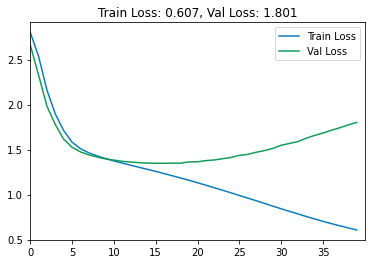

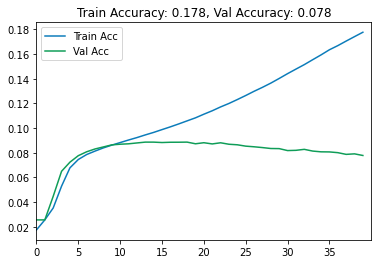

In [ ]:
plot_compare(history.history)

val loss function decreases till about 15 epochs, so model overfitted training dataset.So that shows we should use more samples or less epoch... try changing epochs or sample size

## ChatBot

In [ ]:
def chatbot(sentence):
  ans = predict(model,tokenizer,sentence,meta)
  print("Q: {}\nA: {}\n".format(sentence,ans))

In [ ]:
chatbot('are you mad at me')

Q: are you mad at me
A: never . . . no i am no fucking dead !



In [ ]:
chatbot('lets play something')

Q: lets play something
A: you were not gonna mention that name .



In [ ]:
chatbot('hey you fuck off')

Q: hey you fuck off
A: i am not sure , you are right .



In [ ]:
chatbot('do you know what are you saying?')

Q: do you know what are you saying?
A: i do not know .



## Saving model weights, tokenizer in Google drive

In [ ]:
model.save_weights('transformer_weights.h5')

In [ ]:
tokenizer.save_to_file('tokenizer')

In [ ]:
save_pickle(meta,'meta')

In [ ]:
save_pickle(history.history,'history_transformer')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!cp transformer_weights.h5 '/content/gdrive/My Drive/transformer_weights.h5'
!cp tokenizer.subwords '/content/gdrive/My Drive/tokenizer.subwords'
!cp meta.pickle '/content/gdrive/My Drive/meta.pickle'